# Load covidtracking data and make some plots

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytoolsMH as ptMH
import pandas as pd
import seaborn as sns
import os,sys
import scipy.io
import scipy.stats as ss
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import json
import datetime, dateutil.parser

sns.set_style('whitegrid')

from src import covid_cases as cvdC
from src import covid_deaths as cvdD

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

mpl.rc('pdf', fonttype=42) # embed fonts on pdf output 

r_ = np.r_

## covidtracking.com data

In [2]:
r = requests.get('https://covidtracking.com/api/states/daily')
data = r.json()
ctDf = pd.DataFrame(data)

# save current data
datestr = datetime.datetime.now().strftime('%y%m%d')
ctDf.to_hdf('./ct-data/covidtracking-data-%s.h5'%datestr, key='ct', complevel=9, complib='zlib')

## todo

- place element of xlim
- 2nd plot 
- etc

In [3]:
paramsC = pd.DataFrame(index={'DC','MD','VA','NY'}, columns=['fullname'])
paramsC.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
paramsC.loc[:,'labYOff'] = pd.Series({ 'DC': -15, 'MD': +10, 'VA': -10, 'NY':-15})
paramsC.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': +5, 'NY': 0})
paramsC.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NY': 0.8})
#params.loc[:,'xoff'] = pd.Series({ 'DC': -9, 'MD': -6, 'VA': -6, 'NY': -0.3})
paramsC.loc[:,'xoff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': 0, 'NY': -1})

display(paramsC)

,fullname,labYOff,labXOff,lw,xoff
VA,Virginia,-10,5,2.0,0
DC,District of Columbia,-15,0,2.0,0
MD,Maryland,10,0,2.0,0
NY,NaN,-15,0,0.8,-1


Latest data for DC: 2020-04-02 00:00:00
Latest data for MD: 2020-04-02 00:00:00
Latest data for VA: 2020-04-02 00:00:00
Latest data for NY: 2020-04-02 00:00:00
Latest data for DC: 2020-04-02 00:00:00
Latest data for MD: 2020-04-02 00:00:00
Latest data for VA: 2020-04-02 00:00:00


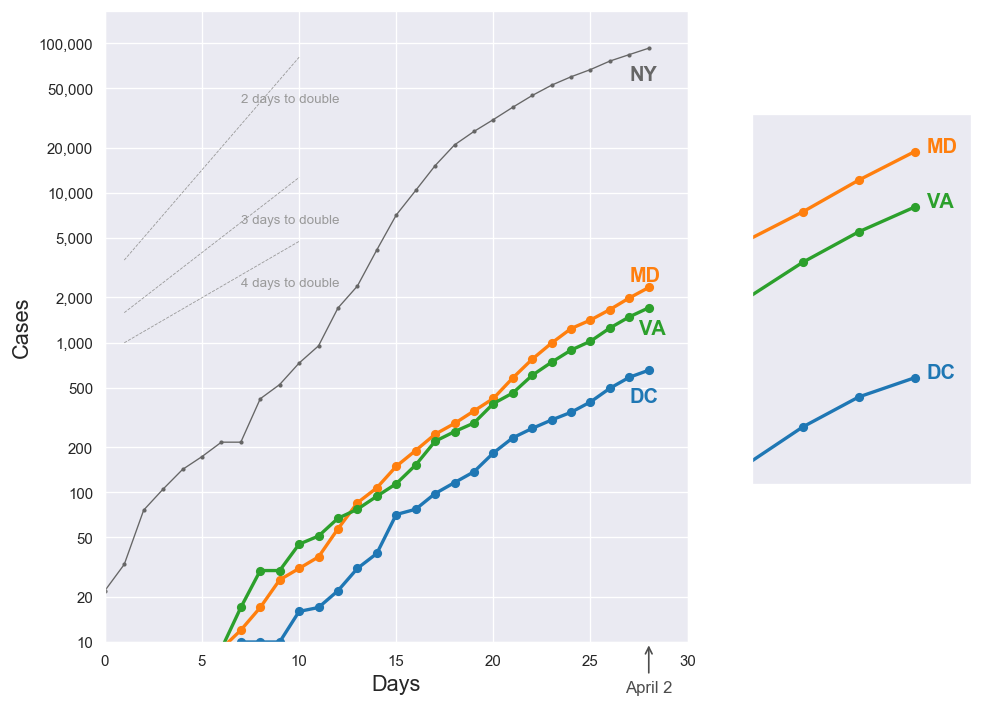

In [4]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)

xlim = r_[0,30]
todayx = 0 #26

# big plot - states
for st in ['DC', 'MD', 'VA', 'NY']:
    cvdC.plot_state(ctDf, st, paramsC, ax, False)

# big plot fixup
cvdC.fixups(ax)
#ADJUST AXIS LIMS TO FIT 
ax.set_xlim(xlim)  
ax.set_ylim([10, ax.get_ylim()[1]])

# inset
ylim = r_[300, 2400] #ADJUST YLIM TO FIT 
axins = cvdC.inset(ctDf, paramsC, ax, ylim, is_inset=True)

#case doubling lines 
xs = r_[1,10] #ADJUST COORDS AS CASES CLIMB
dtL = [2,3,4]
cvdC.case_double(xs, dtL, ax) #might have to adjust in scropt 

#add arrow
ax.annotate('April 2', xy=(28,10), xycoords='data', xytext=(0,-30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='0.3'), 
            color='0.3', ha='center')
# save fig 
fig.tight_layout()
fig.savefig('./fig-output/ct-%s.png'%datestr, dpi=300, bbox_inches='tight', pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 

### Same plot for deaths

In [5]:
paramsD = pd.DataFrame(index={'DC','MD','VA','NJ'}, columns=['fullname'])
paramsD.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
paramsD.loc[:,'labYOff'] = pd.Series({ 'DC': +10, 'MD': -10, 'VA': +15, 'NJ':0})
paramsD.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': +5, 'VA': +5, 'NJ': +10})
paramsD.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NJ': 0.8})
paramsD.loc[:,'xoff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': 0, 'NJ': -1})

Latest data for DC: 2020-04-02 00:00:00
Latest data for MD: 2020-04-02 00:00:00
Latest data for VA: 2020-04-02 00:00:00
Latest data for NJ: 2020-04-02 00:00:00
Latest data for DC: 2020-04-02 00:00:00
Latest data for MD: 2020-04-02 00:00:00
Latest data for VA: 2020-04-02 00:00:00


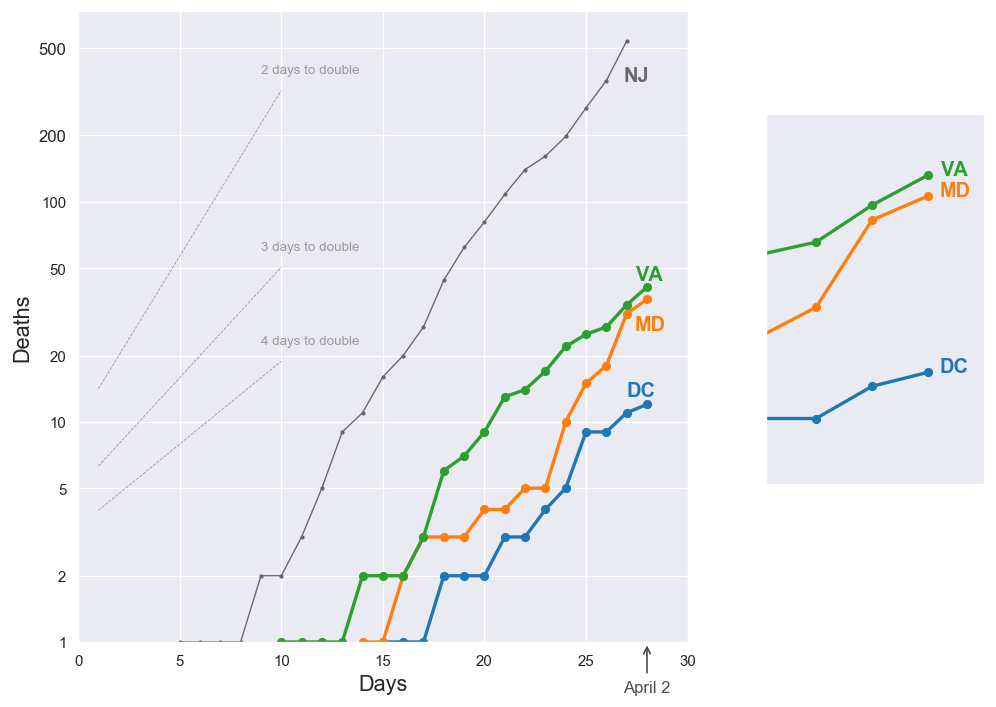

In [6]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)

xlim = r_[0,30]

todayx = 0 #26

for st in ['DC', 'MD', 'VA', 'NJ']:
    cvdD.plot_state(ctDf, st, paramsD, ax, False)

# big plot fixup
cvdD.fixups(ax)
#ADJUST AXIS LIMS TO FIT 
ax.set_xlim(xlim)  
ax.set_ylim([1, ax.get_ylim()[1]])

# inset
ylim = r_[5, 50] #ADJUST YLIM TO FIT 
cvdD.inset(ctDf, paramsD, ax, ylim, is_inset = True)

#Death doubling lines
cvdD.case_double(xs, dtL, ax)

#add arrow
ax.annotate('April 2', xy=(28, 1), xycoords='data', xytext=(0,-30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='0.3'), 
            color='0.3', ha='center')

fig.tight_layout()
fig.savefig('./fig-output/dt-%s.png'%datestr, dpi=300, bbox_inches='tight', pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 